<h1><center>Inteligencia Artificial</center></h1>


<h2><center>Tarea 5 - Inferencia Bayesiana y EDA (Exploración de Datos)</center></h2>

---

#### El **objetivo** de esta tarea es realizar un análisis exploratorio básico sobre el conjunto de datos proporcionado (pedidos de clientes a lo largo del tiempo). 


* Además, deberán agregar su informacción correspondiente del equipo que hayan formado, así como el link de github correspondiente al cual cargarán la notebook (ejecutada previamente), para visualizar las respuestas.

---
<h1 >Integrantes</h1>

Ali Villegas Z A01337596 - [Github](https://github.com/AliVillegas/Sistemas-Inteligentes).

Carlos Julián Herrera H A01114097 - [Github](https://github.com/JulianHerreraH/Sistemas_Inteligentes).

Alfredo Quintero T A01337630 - [Github](https://github.com/alfredoqt/sistemas-inteligentes).

---

### Objetivo

Predecir qué productos estarán en el próximo pedido de un usuario. El conjunto de datos es anónimo y contiene una muestra de más de 3 millones de pedidos de comestibles de más de 200,000 usuarios de Instacart.

Para cada usuario se entregan 4 y 100 de sus pedidos, con la secuencia de productos comprados en cada pedido

<img src="https://shukka.com/img/xeda.PNG.pagespeed.ic.MVCnc5-70D.png" />

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from subprocess import check_output
print(check_output(["ls", "./"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_data



In [3]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")


In [4]:
#Así se despliega información del cabezal del dataframe
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
#Mostrar header de prior y train
order_products_prior.head()


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## ¿Qué contiene cada archivo?
- El archivo de **Orders** contiene los detalles de cada orden, que son:
  - ID, de usuario y de orden
  - Numero de la orden 
  - La hra de la orden y dias que han pasado desde la orden
- El archivo de **Train** y **Prior** tienen los mismas columna, las cuales son:
  - ID de orden y de producto
  - Orden de agregacion al carrito 
  - Y si fue re ordenada  
Para estas dos ultimos archivos la diferencia es que los datos de prior estan como floats.

----

Como se mencionó anteriormente, en este conjunto de datos, se dan de 4 a 100 pedidos de un cliente (lo veremos más adelante) y necesitamos predecir los productos que se volverán a ordenar. Así que el último pedido del usuario se ha extraído y dividido en conjuntos de prueba y de entrenamiento. 

Todas las informaciones de pedidos anteriores del cliente están presentes en el archivo order_products_prior. También podemos notar que hay una columna en el archivo orders.csv llamada eval_set que nos dice a cuál de los tres conjuntos de datos (previo, entrenamiento o prueba) va la fila dada.

-----

Primero obtengamos el recuento de filas en cada uno de los tres conjuntos.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


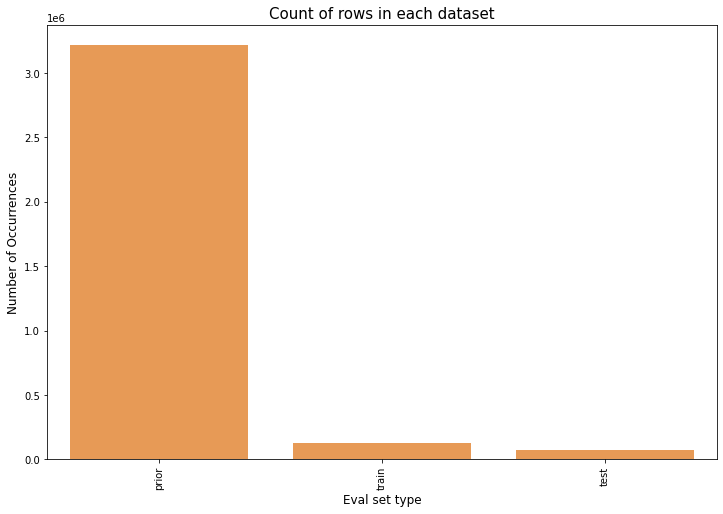

In [7]:
cnt_srs = orders.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [8]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

# ¿Qué significan los valores anterior? Suponiendo que teníamos un total de clientes...
La mayoria de los datos se encuentra en el archivo de prior, para poder determinar el proximo pedido correctamente


Ahora validemos la afirmación de que se dan de 4 a 100 pedidos de un cliente.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 97 Text major ticklabel objects>)

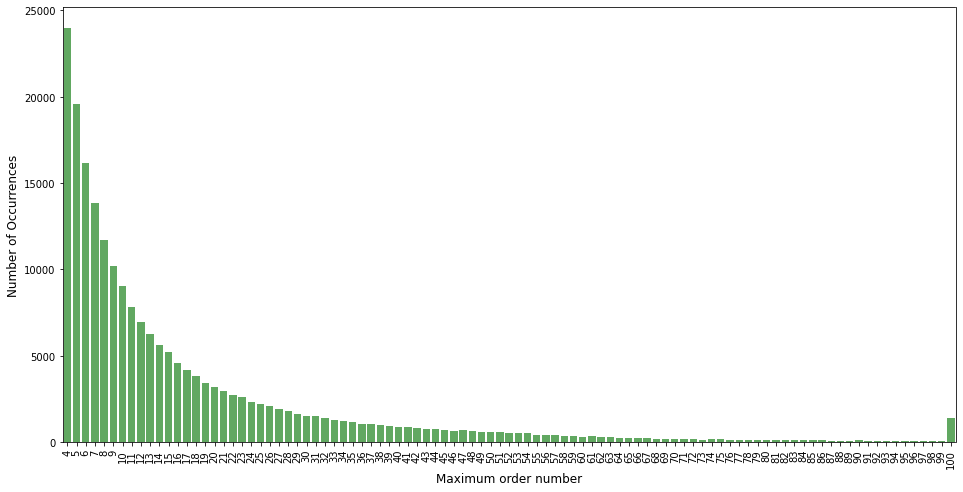

In [9]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')


Por lo tanto, no hay pedidos de menos de 4 y tiene un límite máximo de 100 como se indica en la página de datos.

Ahora veamos cómo cambia el hábito de hacer pedidos con el día de la semana.

Text(0.5, 1.0, 'Frequency of order by week day')

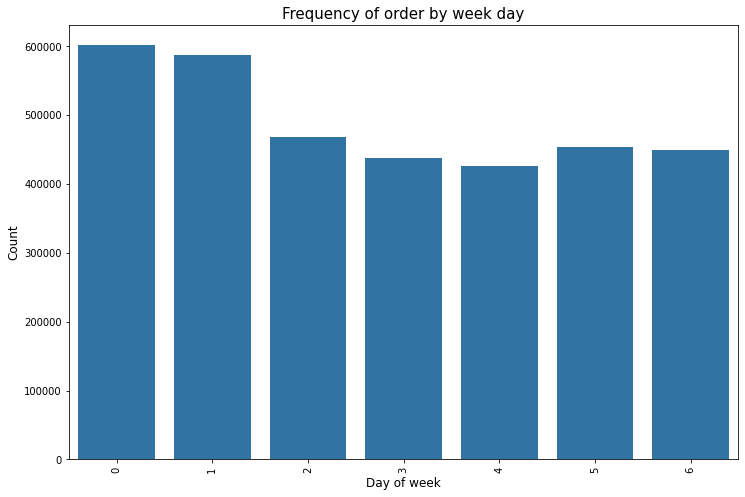

In [10]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)


## ¿Cuáles són los días con mayor y menor cantidad de pedidos?  
Se puede ver que los dias com as frecuencia de ordenes son el 0 y 1, si tomamos como primer dia de la semana el Domingo, podemos obervar que los dias con ams pedidos son el **Domingo y Lunes**.
Por otro lado, los dias con menos ordenes son el 3 y 4, lo cual corresponde a **Miercoles y Jueves**



Ahora veremos cómo es la distribución con respecto a la hora del día.

Text(0.5, 0, 'Hour of day')

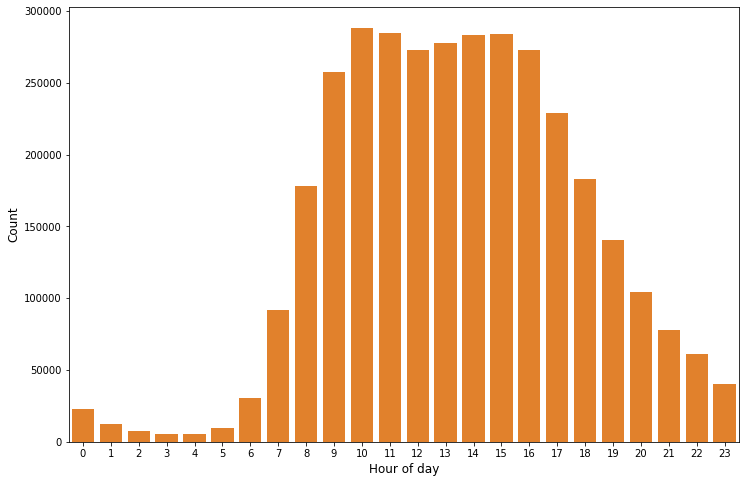

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)


# ¿En qué periodo de tiempo se realiza la mayor cantidad de pedidos? 

Ahora combinemos el día de la semana y la hora del día para ver la distribución.

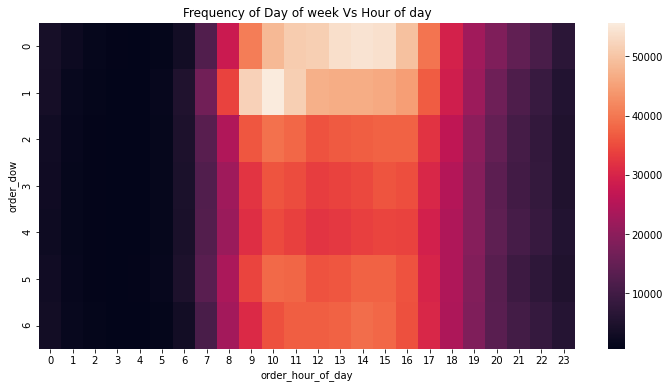

In [12]:
grouped_df = orders.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

# ¿Cuándo es el mejor momento para realizar pedidos acorde a lo anterior?

Como se menciono anteriormente, los dias con mas ordenes son Domingo y Lunes, esto se verifica en la grafica. Ademas se observa que las horas mas ocupadas son el **Domingo de 10 a 16** y el **Lunes de 9 a 11**  
Por lo tanto, los mejores momentos para realizar pedidos son las horas de la madrugada o temprano por la mañana.  
Tambien se puede hacerlo en dias con menos frecuencua, como los miercoles o jueves

---

Ahora revisemos el intervalo de tiempo entre los pedidos.

Text(0.5, 0, 'Days since prior order')

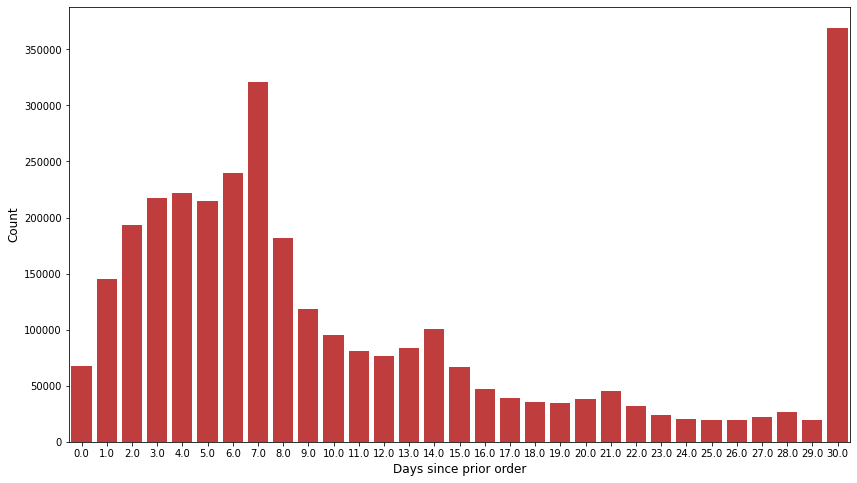

In [13]:
plt.figure(figsize=(14,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)


# Parece que los clientes hacen pedidos... ¿cada cuánto?

Como los pedidos son de alimentos y comestibles, es logico que los clientes hagan pedidos cada **7 dias, es decir, cada semana**. Esto se relaciona con que pidan los domingo, que es cuando inicia la semana.   
De igual forma cada **30 dias** es normal, ya que pasa el mes y piden alimentos y otros productos para el hogar.  

---

# Según la tendencia, ¿hay otros días que muestren picos pequeños?  


Otros dias que presentan picos es cada **6, 4 y 3** que pueden representar compras durante la semana, en caso de que se necesiten alimentos. De igual forma, cada **14 dias** se ve otro pico, ya que puede representar la quincena. 

---


Dado que nuestro objetivo es averiguar los reordenamientos, veamos el porcentaje de reorden en la serie anterior y la serie de trenes.

In [15]:
# percentage of re-orders in prior set #
order_products_prior.reordered.sum() / order_products_prior.shape[0]

0.5896974667922161

In [ ]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

## ¿Qué significan los valores anteriores?

El 59% de los prodcutos son reordenados, lo que muestra que la mayoria de clientes tiene una lista fija de productos que ordena semanalmente 

---

### No hay productos reordenados:

Ahora que hemos visto que el 59% de los productos se vuelven a pedir, también habrá situaciones en las que no se vuelva a pedir ninguno de los productos. Comprobemos eso ahora.

In [16]:
grouped_df = order_products_prior.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [17]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

# ¿Y en esta sección?

Para el set de *prior* se ve que solo el 12% de los productos no son reaordenados y para el *train* solo un 6%

----

Ahora veamos la cantidad de productos comprados en cada pedido.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Number of products in the given order')

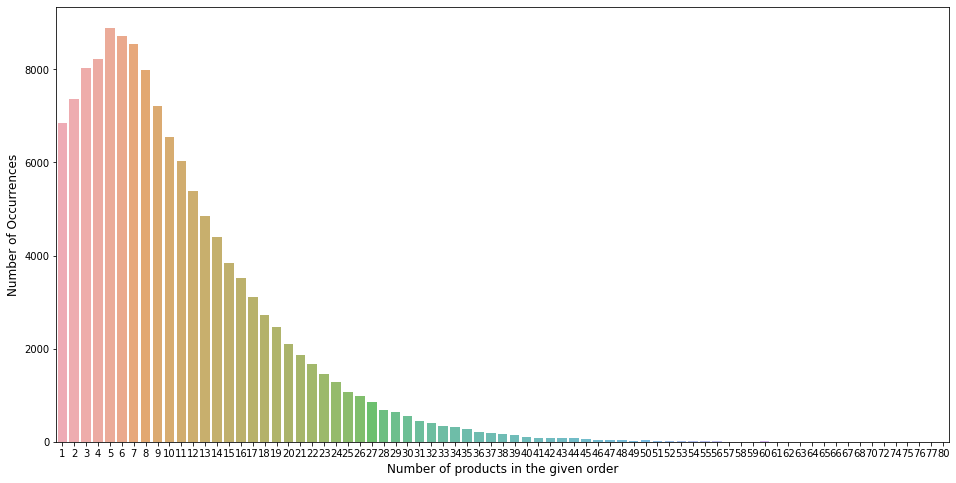

In [18]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)


# ¿Cuál es el valor más alto?

La mayoria de clientes compra **5 productos** seguido de 6, 7 y 8. Esto puede significar que no hacen todas sus compras del hogar por medio de los pedidos. 

---

Antes de explorar los detalles del producto, veamos también los otros tres archivos.

In [19]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [21]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


Ahora fusionemos estos detalles del producto con los detalles de order_prior.

In [22]:
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [23]:
cnt_srs = order_products_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


# ¿Qué podemos inferir de los resultados anteriores?

Los productos mas comprados son frutas y verduras, esto resulta logico ya que estos productos son pedidos frescos y se consumen/dañan rapidamente en los hogares. 

---

Ahora echemos un vistazo a los pasillos importantes.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

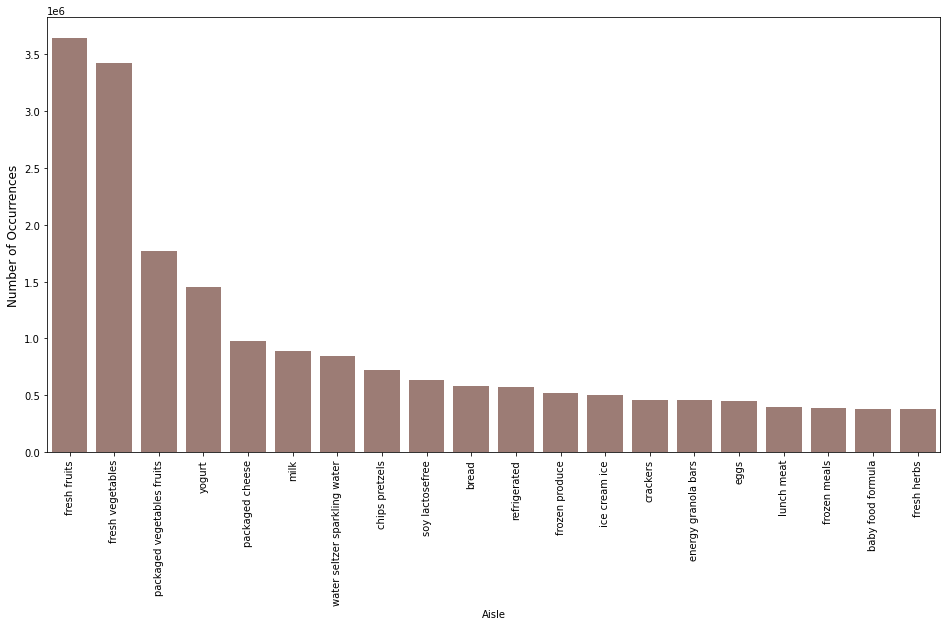

In [24]:
cnt_srs = order_products_prior['aisle'].value_counts().head(20)
plt.figure(figsize=(16,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=10)
plt.xticks(rotation=90)


# ¿Cuáles son los pasillos con mayor valor?

La inferencia anterior puede ser comprobada con esta grafica, los pasillos con mas compras son los de **Fruta frescas y Vegetales**, la diferencia con los otros pasillos es bastante alta

----

### Distribución departamental:

Veamos ahora la distribución inteligente del departamento.


Text(0.5, 1.0, 'Departments distribution')

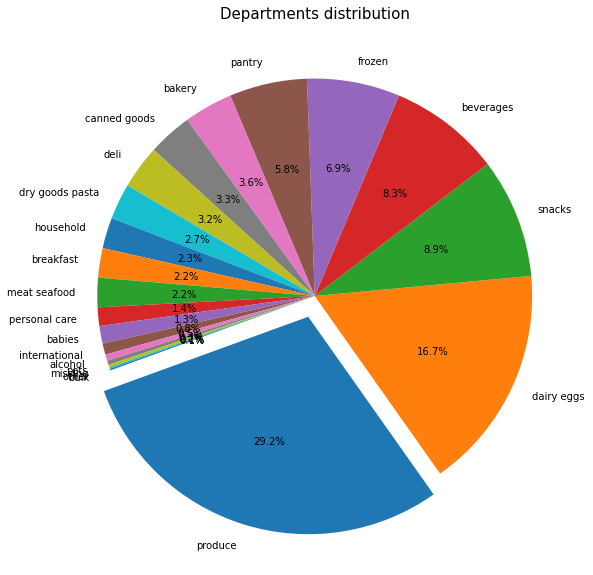

In [25]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
explode = [0 for n in range(len(np.array((temp_series / temp_series.sum())*100)))]
explode[0] = 0.1
plt.pie(sizes, explode=explode, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)

# ¿Cuál es el departamento más grande? y ¿por cuales es seguido?

El departamento mas grande es el de **Produce** que respresenta las verduras y frutas. Seguido por huevos y snacks.  
Los resultados de esta grafica van de acuerdo a los descubrimientos encontrados en las otras graficas, 

---

### Relación de pedidos por departamento:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Orders by Deparment')

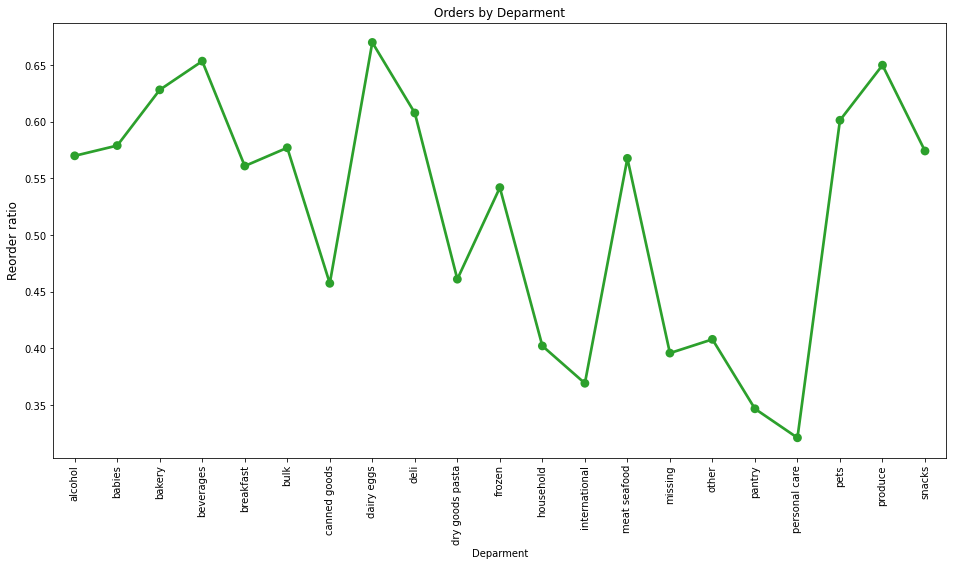

In [26]:
grouped_df = order_products_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df2 = grouped_df.copy()
plt.figure(figsize=(16,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Deparment', fontsize=10)
plt.xticks(rotation=90)
plt.title("Orders by Deparment")


# ¿Cuáles son los departamentos con mayor y menor cantidad de proporción de pedidos?

Reforzando lo visto anteriormente, los departamentos con mayor pedidos don **Produce, Diary/Eggs y Snacks**  
Los que menos pedidos tienen son los de cuidado personal, pantry y productos internacionales

---


### Pasillo - Relación de pedidos:

Text(0.5, 1.0, 'Reorder-Aisle relation')

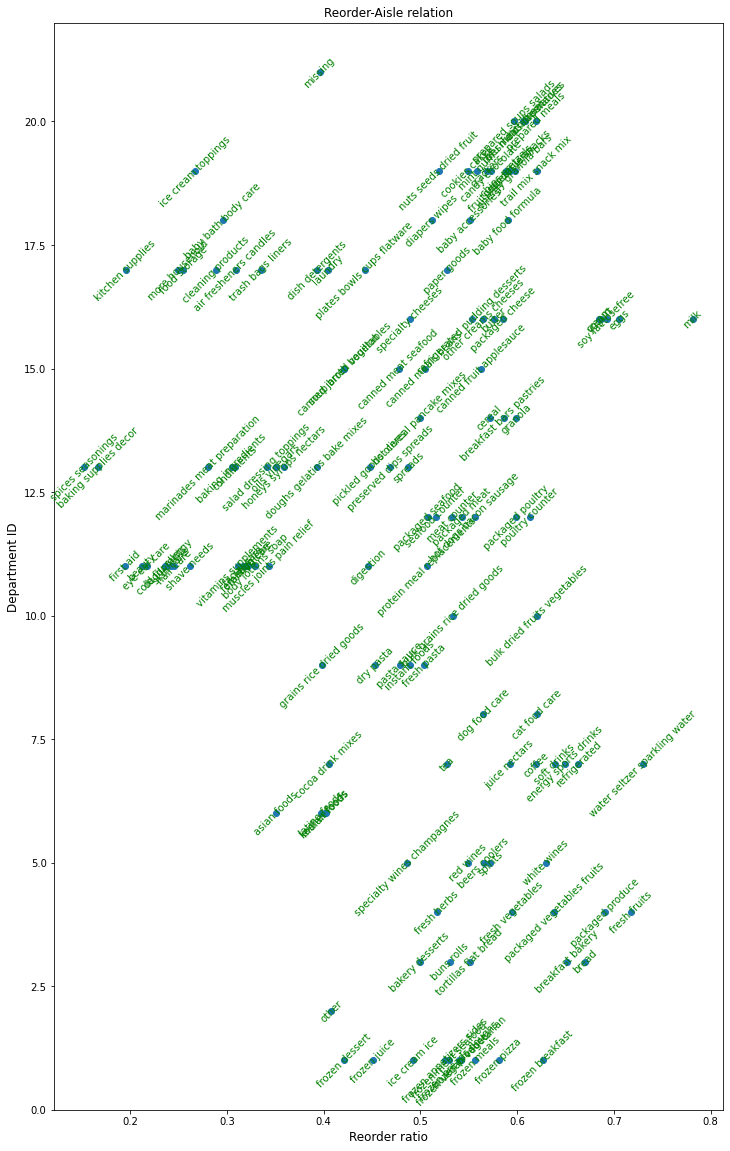

In [27]:
grouped_df = order_products_prior.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.ylabel('Department ID', fontsize=12)
plt.xlabel('Reorder ratio', fontsize=12)
plt.title("Reorder-Aisle relation")


### Agregar al carrito - Relación de pedidos:

Exploremos ahora la relación entre cómo el orden de agregar el producto al carrito afecta la tasa de reorden.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


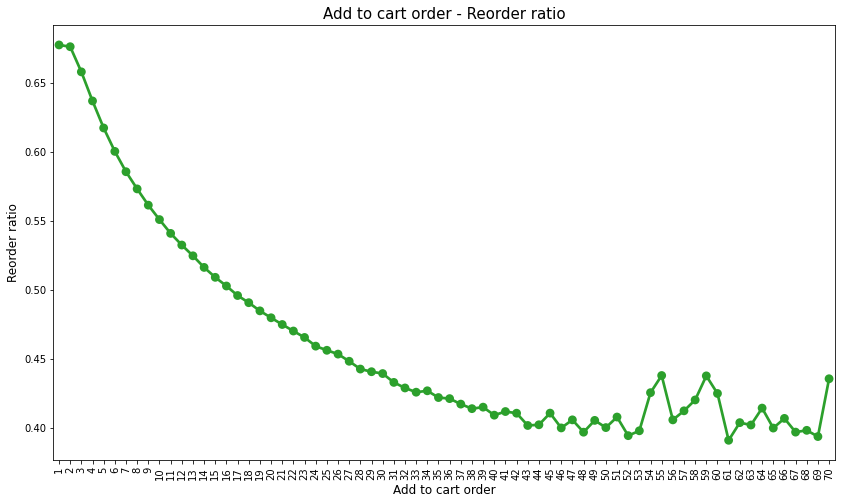

In [28]:
order_products_prior["add_to_cart_order_mod"] = order_products_prior["add_to_cart_order"].copy()
order_products_prior["add_to_cart_order_mod"].loc[order_products_prior["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(14,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

# ¿Qué podemos interpretar de este gráfico? ¿Hay alguna relación a la probabilidad de volver a elegir dicho producto?

Se puede decir que los productos que mas se reordenan son los que mas rapido se agregan al carrito. Si se compran frecuentemente, los clientes los agregan en cuanto los ven o los tienen guardados en listas.   
Resulta interesante los picos en los valores mas altos, puede ser que las compras de ultimo minuto sean del mismo producto para varios clientes.

---


### Reordenar la proporción por variables basadas en el tiempo:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Reorders and DOW relation')

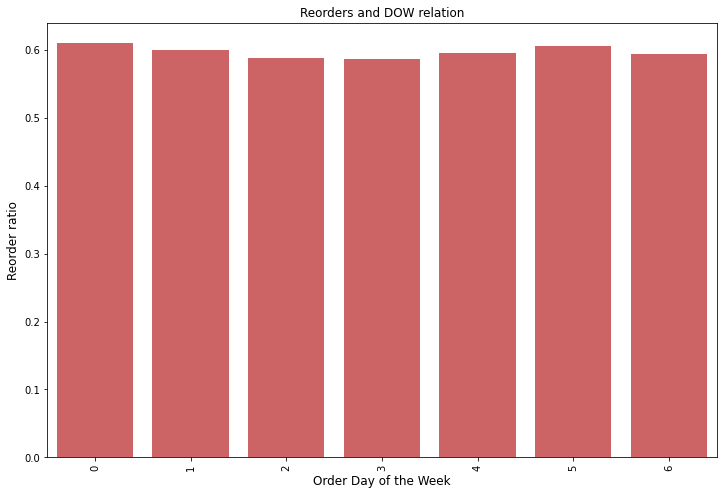

In [29]:
order_products_train_df = pd.merge(order_products_train_df, orders, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Order Day of the Week', fontsize=12)
plt.xticks(rotation=90)
plt.title("Reorders and DOW relation")

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Hour of day')

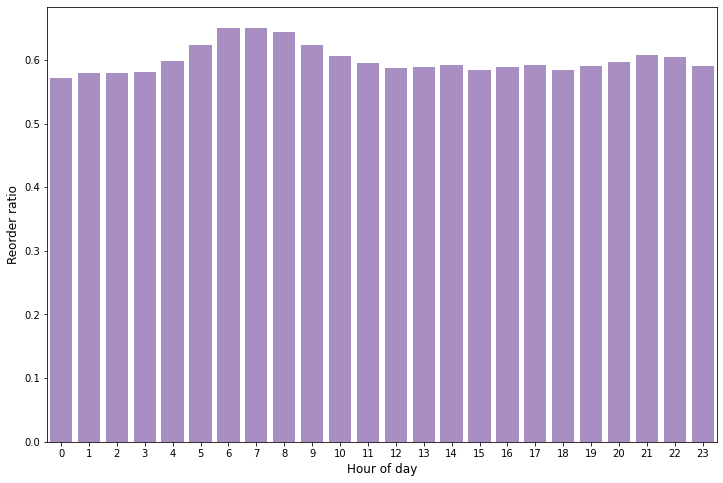

In [30]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)

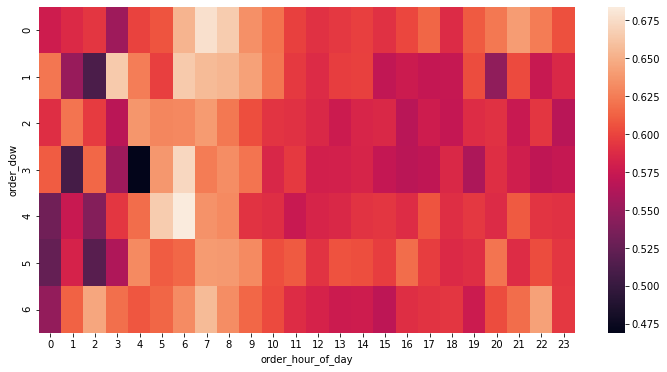

In [31]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)


# ¿Qué podemos inferir de todo lo anterior? ¿Las tasas de reordenar algo en qué momento del día tienen mayor frecuencia?

A partir de las graficas anteriores podemos concluir que el momento del dia, de manera general, en el que mas se hacen reordenes es por la mañana, alrededor de 6 a 8.  
En este caso vemos que los jueves son la hora con la tasa de reorden mas alta, pero los dias con mayor tasa son el Domingo(0) y el Viernes(5)

----


In [4]:
## A partir del siguiente árbol de asociación... 
order_products_prior = pd.merge(order_products_prior, products, on='product_id', how='left')
order_products_prior = pd.merge(order_products_prior, aisles, on='aisle_id', how='left')
order_products_prior = pd.merge(order_products_prior, departments, on='department_id', how='left')
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [5]:
test = order_products_prior.sample(n = 1500)  

In [6]:
test

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
17220928,1816634,24654,9,0,Potato Hot Dog Buns,43,3,buns rolls,bakery
19147492,2019544,23139,8,1,Fresh Goat Cheese Classic,2,16,specialty cheeses,dairy eggs
17086783,1802419,42969,5,1,Herb Turkey Breast,96,20,lunch meat,deli
14114579,1489602,25138,8,0,Organic Plain Greek Whole Milk Yogurt,120,16,yogurt,dairy eggs
25050878,2642045,9387,13,1,Granny Smith Apples,24,4,fresh fruits,produce
...,...,...,...,...,...,...,...,...,...
18344679,1934997,4071,28,0,Organic Lemongrass Ginger Ramen,66,6,asian foods,international
26160455,2758838,24852,1,1,Banana,24,4,fresh fruits,produce
4671762,493023,10467,16,1,Organic Bernie O's,59,15,canned meals beans,canned goods
24555296,2589756,22825,16,1,Organic D'Anjou Pears,24,4,fresh fruits,produce


In [8]:
import plotly.express as px 
    
fig = px.treemap(test, path=['department', 'product_name'], values='add_to_cart_order') 
  
fig.show()

¿Cuántos productos únicos se ofrecen en cada departamento / pasillo?

El tamaño de las cajas muestra la cantidad de productos en cada categoría.

Como se vio a lo largo de la notebook, los recuadros mas grandes con Produce, Diary/Eggs y Snacks, estos son los mas comprados y reordenados.  
Tambien son los que tienen mas productos, lo que puede influenciar la cantidad de veces que se repiten en las ordenes.   
Por ultimo, anteriormente se vio que el departamente de Produce era el 29% del total. 